# US Name

Estimate tangible asset as a function of  current ratio and others (Evaluate role of internal finance) 

# Business needs 

Estimate tangible asset as a function of  current ratio, cash_over_total_asset, liabilities over asset, Cash flow to total asset, cash flow to total tangible asset, credit constraint (Evaluate the impact of internal finance on asset) 

## Description
### Objective 

Test the coefficient sign and significant of the main variable

### Tables

Table 1: Baseline Estimate, tangible asset and current ratio, cash_over_total_asset, liabilities over asset, Cash flow to total asset, cash flow to total tangible asset, credit constraint

**Cautious**
Make sure no empty rows, otherwise it will be filtered out in the estimate


# Metadata

- Key: gac25vjvp54377n
- Epic: Models
- US: Internal finance estimate
- Task tag: #internal-finance, #credit-constraint, #firm-level
- Analytics reports: 

# Input Cloud Storage

## Table/file

**Name** 

- https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/09_asif_tfp_firm_baseline.md

**Github**

- DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/TFP/CREDIT_CONSTRAINT



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

R has a hard time importing correctly values with many missing values, so to force R to import `rd_tot_asset` as a float, we use the following trick

- `rd_tot_asset` lowest value is -.013. Hence, when `rd_tot_asset` is missing replace by -1000

In [5]:
db = 'firms_survey'
table = 'asif_tfp_credit_constraint'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
download_data = True
filename = 'df_{}_rd'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT *,
    CASE WHEN rd_tot_asset IS NULL THEN -1000 
    WHEN rd_tot_asset < 0 THEN 0
    ELSE rd_tot_asset END AS rd_tot_asset_trick
    FROM {}.{}
    WHERE
    cashflow_to_tangible > 0
    AND current_ratio > 0
    AND liabilities_tot_asset > 0
    AND year in (
        '2001', '2002', '2003', '2004', '2005', 
        '2006', '2007'
      )
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
            )
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [8]:
pd.DataFrame(schema)

,Name,Type,Comment
0,firm,string,firm ID
1,year,string,year
2,period,varchar(5),if year prior to 2006 then False else true. Indicate break from 10 and 11 FYP
3,cic,string,4 digits industry code
4,indu_2,string,"Two digits industry. If length cic equals to 3, then add 0 to indu_2"
...,...,...,...
73,count_city,string,
74,count_industry,string,
75,fe_c_i,bigint,City industry fixed effect
76,fe_t_i,bigint,year industry fixed effect


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [9]:
add_to_dic = True
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
        data = {'to_rename':[], 'to_remove':[]}
    dic_rename =  [
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        ### depd
        {
        'old':'total\_asset',
        'new':'\\text{size}'
        },
        {
        'old':'tangible',
        'new':'\\text{tangible asset}'
        },
        {
        'old':'investment\_tot\_asset',
        'new':'\\text{investment to asset}'
        },
        {
        'old':'rd\_tot\_asset',
        'new':'\\text{rd to asset}'
        },
        {
        'old':'asset\_tangibility\_tot\_asset',
        'new':'\\text{collateral}'
        },
        
        ### ind
        {
        'old':'current\_ratio',
        'new':'\\text{current ratio}'
        },
        {
        'old':'quick\_ratio',
        'new':'\\text{quick ratio}'
        },
        {
        'old':'liabilities\_tot\_asset',
        'new':'\\text{liabilities to asset}'
        },
        {
        'old':'sales\_tot\_asset',
        'new':'\\text{sales to asset}'
        },
        {
        'old':'cash\_tot\_asset',
        'new':'\\text{cash to asset}'
        },
        {
        'old':'cashflow\_tot\_asset',
        'new':'\\text{cashflow to asset}'
        },
        {
        'old':'cashflow\_to\_tangible',
        'new':'\\text{cashflow}'
        },
        {
        'old':'d\_credit\_constraintBELOW',
        'new':'\\text{Fin dep}_{i}'
        },
        ## control
        {
        'old':'age + 1',
        'new':'\\text{age}'
        },
        {
        'old':'export\_to\_sale',
        'new':'\\text{export to sale}'
        },
        {
        'old':'labor\_capital',
        'new':'\\text{labor to capital}'
        },
        ### Supply demand external finance
        {
        'old':'supply\_all\_credit',
        'new':'\\text{all credit}'
        },
        {
        'old':'supply\_long\_term\_credit',
        'new':'\\text{long term credit}'
        },
        {
        'old':'credit\_constraint',
        'new':'\\text{credit demand}'
        },
        {
        'old':'soe\_vs\_priPRIVATE',
        'new':'\\text{private}'
        },
    ]
    

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [10]:
import function.latex_beautify as lb

#%load_ext autoreload
#%autoreload 2

In [11]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "function/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [12]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE'),
    soe_vs_pri = relevel(as.factor(soe_vs_pri), ref='SOE'))

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  short = col_character(),
  province_en = col_character(),
  ownership = col_character(),
  soe_vs_pri = col_character(),
  for_vs_dom = col_character(),
  d_credit_constraint = col_character(),
  rd_tot_asset = col_logical(),
  avg_size_asset_fci = col_character(),
  avg_size_output_fci = col_character(),
  avg_employment_fci = col_character(),
  avg_size_capital_fci = col_character(),
  avg_sales_fci = col_character(),
  size_asset_fci = col_character(),
  size_asset_fc = col_character(),
  size_asset_fi = col_character(),
  size_output_fci = col_character(),
  size_output_fc = col_character(),
  size_output_fi = col_character(),
  size_employment_fci = col_character()
  # ... with 8 more columns
)
See spec(...) for full column specifications.


In [13]:
glimpse(df_final)

Observations: 216,269
Variables: 79
$ firm                        <dbl> 316355, 407727, 63480, 254141, 367939, 47…
$ year                        <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004,…
$ period                      <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE,…
$ cic                         <dbl> 2221, 3020, 3592, 1440, 3521, 3529, 2110,…
$ indu_2                      <dbl> 22, 30, 35, 14, 35, 35, 21, 14, 17, 31, 3…
$ short                       <fct> Paper, Plastics, Machinery, Foods, Machin…
$ geocode4_corr               <dbl> 2302, 2302, 2302, 2302, 2302, 2302, 2302,…
$ province_en                 <fct> Heilongjiang, Heilongjiang, Heilongjiang,…
$ tcz                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ spz                         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ ownership                   <fct> FOREIGN, PRIVATE, SOE, PRIVATE, COLLECTIV…
$ soe_vs_pri                  <fct> PRIVATE, PRIVATE, SOE, PRIVATE, PRIVATE, …
$ for_vs_dom    

## Table 1: Channel of transmission: Asset accumulation

$$
\begin{aligned}
\text { (Asset) }_{i t}= \beta_{1}\text {Cash flow}_{fit}+\beta_{2}\text {Current ratio}_{fit}+\beta_{3}\text {liabilities to asset}_{fit} + \beta_{4}\text {X}_{fit} +\epsilon_{fit}
\end{aligned}
$$

* Column 1: tangible to total asset
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`
* Column 2: RD to total asset
    * FE: 
        - fe 1: `firm`
        - fe 2: `industry-year`

In [14]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [15]:
%get path table
t_0 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | firm + year + indu_2|0 | firm,df_final,
            exactDOF = TRUE)

t_1 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale 
            | firm + year + indu_2|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007")),
            exactDOF = TRUE)

## All credits
t_2 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_all_credit
            | firm + year + indu_2|0 | firm,df_final,
            exactDOF = TRUE)

t_3 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_all_credit
            | year + indu_2|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007")),
            exactDOF = TRUE)

## LT credit
t_4 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_long_term_credit
            | firm + year + indu_2|0 | firm,df_final,
            exactDOF = TRUE)

t_5 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            supply_long_term_credit
            | year + indu_2|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007")),
            exactDOF = TRUE)

## Credit demand
t_6 <- felm(log(asset_tangibility_tot_asset) ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            credit_constraint
            | firm + year|0 | firm,df_final,
            exactDOF = TRUE)

t_7 <- felm(rd_tot_asset_trick ~
            log(cashflow_to_tangible) +
            log(current_ratio) +
            log(liabilities_tot_asset) +
            log(age) +
            export_to_sale +
            credit_constraint
            | firm + year|0 | firm,df_final %>% filter(year %in% list("2005","2006", "2007")),
            exactDOF = TRUE)

            
dep <- "Dependent variable"
fe1 <- list(
    c("firm", "Yes", "Yes", "Yes", "No", "Yes", "No", "Yes", "Yes"),
    c("industry", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "No", "No"),
    c("year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )

table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5, t_6, t_7
),
    title="Channel of transmission Asset accumulation",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
) 

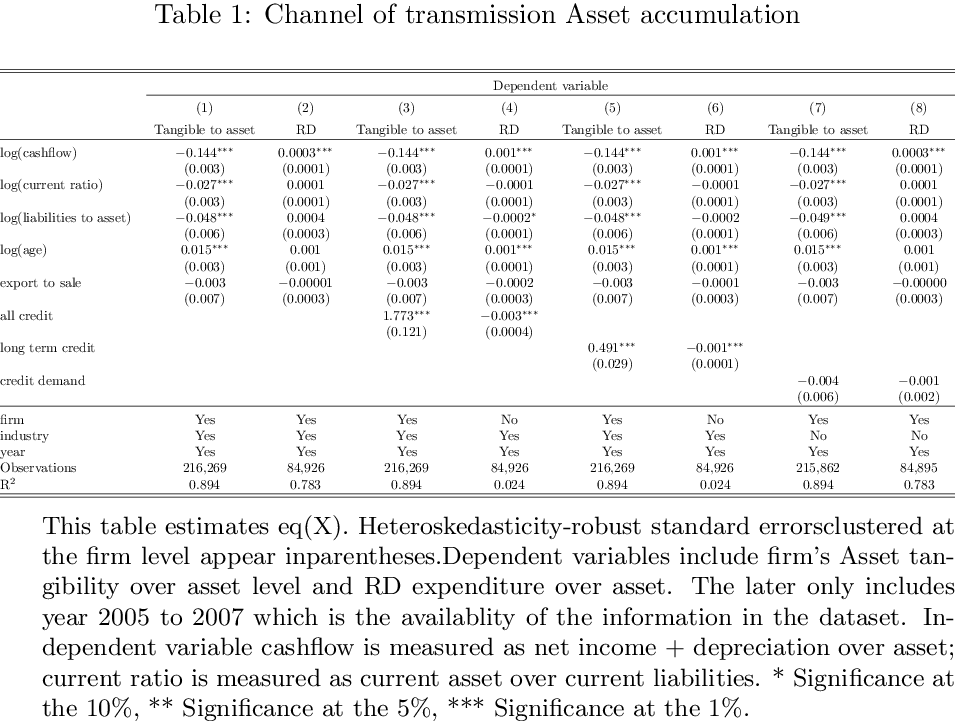

In [16]:
tbe1  = "This table estimates eq(X). " \
"Heteroskedasticity-robust standard errors" \
"clustered at the firm level appear inparentheses."\
"Dependent variables include firm's Asset tangibility over asset level and RD expenditure over asset." \
" The later only includes year 2005 to 2007 which is the availablity of the information in the dataset." \
" Independent variable cashflow is measured as net income + depreciation over asset;"\
" current ratio is measured as current asset over current liabilities. " \
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'Tangible to asset': 2,
    'RD': 2,
    'Tangible to asset': 2,
    'Rd': 2
}


#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Tangible to asset', 'RD', 'Tangible to asset', 'RD', 'Tangible to asset', 'RD', 'Tangible to asset', 'RD']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 200,
            folder = folder)

In [17]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

# Generate reports

In [18]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [19]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = False, notebookname = "06_internal_finance_firm_level.ipynb")